# Chapter 9
- 9장 이후를 공부하기 위해서는 4장에 대한 내용 이해가 필요함

In [1]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "tensorflow"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## 1. 설치
### 관리자 귄한으로 cmd, 또는 anaconda prompt 실행 후 다음 명령어를 입력
- pip install --upgrade setuptools
- pip install tensorflow
- pip install keras
- pip install sklearn

## 2. 첫번째 계산 그래프를 만들어 세션에서 실행하기

In [2]:
import tensorflow as tf

x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x**2*y + y + 2 # 계산 그래프만 생성, 어떤 계산도 수행하지 않음

In [3]:
# 세션을 만들고 변수를 초기화한 다음 함수 f를 평가하고 세션을 닫음

sess = tf.Session() # 세션 만들기
sess.run(x.initializer) # 변수 x 초기화
sess.run(y.initializer) # 변수 y 초기화
result = sess.run(f) # f 평가
print(result)
sess.close() # 세션 닫기 (자원 해체)

42


In [4]:
# 더 간단한 방법

with tf.Session() as sess: # with 문에서 선언한 세션이 기본 세션으로 지정
    x.initializer.run() # tf.get_default_session().run(x.initializer) 를 호출하는 것과 동일
    y.initializer.run() # tf.get_default_session().run(y.initializer) 를 호출하는 것과 동일
    result = f.eval() # tf.get_default_session().run(f) 를 호출하는 것과 동일 

In [5]:
init = tf.global_variables_initializer() # 초기화를 바로 수행하지 않고 계산 그래프가 실행될 때 모든 변수를 초기화할 노드 생성

with tf.Session() as sess:
    init.run() # 실제 모든 변수 초기화
    result = f.eval() # f 평가

In [6]:
sess = tf.InteractiveSession() # 자동으로 자신을 기본 세션으로 지정 (with 블록이 필요 없음)
init.run()
result = f.eval()
print(result)
sess.close() # 수동으로 세션을 종료해주어야 함

42


#### tensorflow program의 구성
- 계산 그래프 만들기 (구성단계)
   - 훈련에 필요한 계산과 머신러닝 모델을 표현한 계산 그래프 만들기 
- 그래프 실행 (실행단계)
   - 훈련 스텝을 반복해서 평가하고, 모델 파라미터를 점진적으로 개선하기 위해 반복 루프 수행

## 3. 계산 그래프 관리

In [7]:
reset_graph()

# 노드를 만들면 자동으로 기본 계산 그래프에 추가됨
x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In [8]:
# 독립적인 여러 개의 계산 그래프 만들기
graph = tf.Graph()
with graph.as_default(): # with 블록 안에서만 사용하는 임시 그래프 생성
    x2 = tf.Variable(2)

In [9]:
x2.graph is graph

True

In [10]:
x2.graph is tf.get_default_graph()

False

In [11]:
# tf.reset_default_graph() 로 기본 그래프를 초기화할 수 있음 
# 실험적인 작업을 하는 동안 기본 그래프에 중복된 노드가 많이 포함됨

## 4. 노드 값의 생애주기

In [12]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3
# x는 w에 의존, y와 z는 x에 의존함을 자동으로 감지

with tf.Session() as sess:
    print(y.eval())
    print(z.eval())

10
15


In [13]:
# y와 z를 한번에 평가
with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)
    print(z_val)

10
15


## 5. tensorflow를 이용한 linear regression

### 캘리포니아 주택 가격 데이터셋에 선형 회귀를 수행

In [14]:
# 데이터셋 추출
import numpy as np
from sklearn.datasets import fetch_california_housing

reset_graph()

# 모든 훈련 샘플에 편향에 대한 특성(x0=1) 입력
housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

# 두개의 텐서플로 상수 노드 X(data), y(target)를 만들기
X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)),XT), y) # normal equation

with tf.Session() as sess:
    theta_value = theta.eval() # theta 평가

In [15]:
theta_value

array([[-3.6894890e+01],
       [ 4.3661433e-01],
       [ 9.4453208e-03],
       [-1.0704148e-01],
       [ 6.4345831e-01],
       [-3.9632569e-06],
       [-3.7880042e-03],
       [-4.2093179e-01],
       [-4.3400639e-01]], dtype=float32)

## 6. 경사하강법(gradient descent) 구현

### 직접 gradient 계산

In [16]:
# 특성 벡터의 스케일 조정 (훈련 속도 절감)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

In [17]:
print(scaled_housing_data_plus_bias.mean(axis=0))
print(scaled_housing_data_plus_bias.mean(axis=1))
print(scaled_housing_data_plus_bias.mean())
print(scaled_housing_data_plus_bias.shape)

[ 1.00000000e+00  6.60969987e-17  5.50808322e-18  6.60969987e-17
 -1.06030602e-16 -1.10161664e-17  3.44255201e-18 -1.07958431e-15
 -8.52651283e-15]
[ 0.38915536  0.36424355  0.5116157  ... -0.06612179 -0.06360587
  0.01359031]
0.11111111111111005
(20640, 9)


In [18]:
reset_graph()

n_epochs = 1000 # 훈련단계 1000번 반복
learning_rate = 0.01 # 학습률 eta 설정

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse") # mean squared error
gradients = 2/m * tf.matmul(tf.transpose(X), error) # MSE를 theta에 대해 수동미분 
training_op = tf.assign(theta, theta - learning_rate * gradients) # 반복적인 batch gradient descent step 구현

init = tf.global_variables_initializer() # 훈련 전 변수 초기화

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0: # 100번 반복시마다 MSE의 값 출력
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
        
    best_theta = theta.eval()    

Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.71450055
Epoch 200 MSE = 0.56670487
Epoch 300 MSE = 0.55557173
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436363
Epoch 600 MSE = 0.53962904
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.53406775
Epoch 900 MSE = 0.5321473


In [19]:
best_theta

array([[ 2.0685523 ],
       [ 0.8874027 ],
       [ 0.14401656],
       [-0.34770885],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.66145283],
       [-0.6375278 ]], dtype=float32)

### 자동미분(autodiff) 사용

#### gradients 사용
- 하나의 연산과 변수 리스트를 받아 각 변수에 대한 연산의 gradient를 계산하는 새로운 연산을 만듬.
- tensorflow는 후진모드 자동미분(reverse-mode autodiff)을 사용.

In [20]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

gradients = tf.gradients(mse, [theta])[0] # theta에 대한 MSE의 gradient vector 계산
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("best_theta:")
print(best_theta)

Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.7145004
Epoch 200 MSE = 0.56670487
Epoch 300 MSE = 0.55557173
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436363
Epoch 600 MSE = 0.53962904
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.53406775
Epoch 900 MSE = 0.5321473
best_theta:
[[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]]


#### optimizer 사용

In [21]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse) # theta에 대한 MSE의 gradient vector 계산 

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("best_theta:")
print(best_theta)

Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.7145004
Epoch 200 MSE = 0.56670487
Epoch 300 MSE = 0.55557173
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436363
Epoch 600 MSE = 0.53962904
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.53406775
Epoch 900 MSE = 0.5321473
best_theta:
[[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]]


#### momentum optimizer 사용
- 경사하강법보다 종종 더 빠르게 수렴

In [22]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
training_op = optimizer.minimize(mse) # theta에 대한 MSE의 gradient vector 계산 

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("best_theta:")
print(best_theta)

Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.53056407
Epoch 200 MSE = 0.52501124
Epoch 300 MSE = 0.52441067
Epoch 400 MSE = 0.52433294
Epoch 500 MSE = 0.5243226
Epoch 600 MSE = 0.5243211
Epoch 700 MSE = 0.524321
Epoch 800 MSE = 0.524321
Epoch 900 MSE = 0.524321
best_theta:
[[ 2.068558  ]
 [ 0.8296286 ]
 [ 0.11875337]
 [-0.26554456]
 [ 0.3057109 ]
 [-0.00450251]
 [-0.03932662]
 [-0.89986444]
 [-0.87052065]]


## 7. 훈련 알고리즘에 데이터 주입

### placeholder node
- 실제 계산을 하지 않는 특수한 노드
- 실행 시 주입한 데이터를 출력만 함

In [23]:
reset_graph()

A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict = {A : [[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict = {A : [[4, 5, 6], [7, 8, 9]]})

In [24]:
print(B_val_1)

[[6. 7. 8.]]


In [25]:
print(B_val_2)

[[ 9. 10. 11.]
 [12. 13. 14.]]


### mini-batch gradient descent algorithm
- 임의의 작은 샘플 세트(mini-batch)에 대해 gradient를 계산

In [26]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse) 

init = tf.global_variables_initializer()

n_epochs = 10

batch_size = 100
n_batches = int(np.ceil(m / batch_size))

# mini-batch를 추출하기 위한 함수
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  
    indices = np.random.randint(m, size=batch_size)  
    X_batch = scaled_housing_data_plus_bias[indices] 
    y_batch = housing.target.reshape(-1, 1)[indices] 
    return X_batch, y_batch

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

In [27]:
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255151],
       [-0.31211874],
       [ 0.38510373],
       [ 0.00434168],
       [-0.01232954],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

## 8. 모델 저장과 복원
### 목적
- 훈련시킨 모델을 필요할 때 다시 쓸 수 있도록 모델 파라미터를 디스크에 저장
- 훈련하는 동안 일정한 간격으로 check point를 저장해두면 컴퓨터가 중간에 문제를 일으켜도 마지막 check point에서 부터 점검할 수 있음

In [28]:
reset_graph()

n_epochs = 1000                                                                       
learning_rate = 0.01                                                                  

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")            
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")            
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")                                      
error = y_pred - y                                                                    
mse = tf.reduce_mean(tf.square(error), name="mse")                                    
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)            
training_op = optimizer.minimize(mse)                                                 

init = tf.global_variables_initializer()
saver = tf.train.Saver() # 모델 저장

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0: # 100번의 반복마다 check point 저장
            print("에포크", epoch, "MSE =", mse.eval())                                
            save_path = saver.save(sess, "/tmp/my_model.ckpt")
        sess.run(training_op)
    
    best_theta = theta.eval()
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt") # 최종모델 저장

에포크 0 MSE = 9.161542
에포크 100 MSE = 0.7145004
에포크 200 MSE = 0.56670487
에포크 300 MSE = 0.55557173
에포크 400 MSE = 0.5488112
에포크 500 MSE = 0.5436363
에포크 600 MSE = 0.53962904
에포크 700 MSE = 0.5365092
에포크 800 MSE = 0.53406775
에포크 900 MSE = 0.5321473


In [29]:
best_theta

array([[ 2.0685525 ],
       [ 0.8874027 ],
       [ 0.14401658],
       [-0.34770882],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.6614528 ],
       [-0.6375277 ]], dtype=float32)

In [30]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt") # 모델 복원
    best_theta_restored = theta.eval()

W1019 10:57:48.934835 17028 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [31]:
np.allclose(best_theta, best_theta_restored) # theta 초기화

True

In [32]:
# 변수 theta를 'weight'라는 이름으로 저장하고 복원하는 경우... 
saver = tf.train.Saver({"weights": theta})

- save() 는 기본적으로 .meta 확장자를 가진 동일 이름의 두번째 파일에 그래프의 구조를 저장함
- 반환된 Saver 인스턴스로 그래프의 상태(변숫값)를 복원하는 데 이용할 수 있음

In [33]:
saver = tf.train.import_meta_graph("/tmp/my_model_final.ckpt.meta")  # 그래프 구조를 로드
theta = tf.get_default_graph().get_tensor_by_name("theta:0") 

with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")  # 모델 복원
    best_theta_restored = theta.eval() 

In [34]:
np.allclose(best_theta, best_theta_restored)

True

## 9. tensorboard로 그래프와 학습 곡선 시각화하기

### 만들어진 통계가 합쳐져서 텐서보드 그래프가 엉망이 되는 것을 막기 위해 반드시 프로그램을 실행할 때마다 다른 로그 디렉터리를 사용해야 함

#### 관리자 귄한으로 cmd, 또는 anaconda prompt 실행 후 다음 명령어를 입력
- pip install jupyter-tensorboard 

#### 코드 실행 이후 해당파일(여기에서는 tf_logs)에 체크표시를 하고 tensorboard라는 네모상자를 클릭하여 결과를 확인

In [35]:
from datetime import datetime

# 로그 디렉터리 이름에 타임스템프 포함
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [36]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [37]:
mse_summary = tf.summary.scalar('MSE', mse) # MSE 평가 후 로그문자열 summary에 쓰기 위한 노드 추가
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph()) # FileWriter 객체를 만들어 로그 디렉터리에 있는 로그 파일에 summary를 기록

In [38]:
n_epochs = 10 # mse_summary 노드를 정기적으로 미니배치 10회마다 평가하도록 지정
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:                                                      
    sess.run(init)                                                                

    for epoch in range(n_epochs):                                                 
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()    

In [39]:
file_writer.close() # FileWriter 객체 닫기

In [40]:
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255151],
       [-0.31211874],
       [ 0.38510373],
       [ 0.00434168],
       [-0.01232954],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

## 10. 이름 범위(name scope)

In [41]:
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

In [42]:
with tf.name_scope("loss") as scope: # 'loss' 이름 범위 안에 있는 error와 MSE 정의
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")

In [43]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [44]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

file_writer.flush()
file_writer.close()
print("best_theta:")
print(best_theta)

best_theta:
[[ 2.0703337 ]
 [ 0.8637145 ]
 [ 0.12255151]
 [-0.31211874]
 [ 0.38510373]
 [ 0.00434168]
 [-0.01232954]
 [-0.83376896]
 [-0.8030471 ]]


In [45]:
print(error.op.name)

loss/sub


In [46]:
print(mse.op.name)

loss/mse


## 11. 모듈화

### 두개의 ReLU(rectified linear unit) 출력을 더하는 그래프 만들기

In [47]:
reset_graph()

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")

w1 = tf.Variable(tf.random_normal((n_features, 1)), name="weights1")
w2 = tf.Variable(tf.random_normal((n_features, 1)), name="weights2")
b1 = tf.Variable(0.0, name="bias1")
b2 = tf.Variable(0.0, name="bias2")

z1 = tf.add(tf.matmul(X, w1), b1, name="z1")
z2 = tf.add(tf.matmul(X, w2), b2, name="z2")

relu1 = tf.maximum(z1, 0.0, name="relu1")
relu2 = tf.maximum(z2, 0.0, name="relu2")

output = tf.add(relu1, relu2, name="output")

# 매우 반복적인 코드... 유지 보수가 어렵고 에러가 발생하기 쉬움

### ReLU를 구현하는 함수를 만들면 해결 가능

In [48]:
reset_graph()

def relu(X):
    w_shape = (int(X.get_shape()[1]), 1)
    w = tf.Variable(tf.random_normal(w_shape), name="weights")
    b = tf.Variable(0.0, name="bias")
    z = tf.add(tf.matmul(X, w), b, name="z")
    return tf.maximum(z, 0., name="relu")

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

In [49]:
file_writer = tf.summary.FileWriter("logs/relu1", tf.get_default_graph())

### name scope를 사용하면 더 간결해짐

In [50]:
reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)                          
        w = tf.Variable(tf.random_normal(w_shape), name="weights")    
        b = tf.Variable(0.0, name="bias")                             
        z = tf.add(tf.matmul(X, w), b, name="z")                      
        return tf.maximum(z, 0., name="max")

In [51]:
n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("logs/relu2", tf.get_default_graph())
file_writer.close()

## 12. 변수공유

### 목적
- 그래프의 여러 구성 요소 간에 변수를 공유
- 변수를 먼저 만들고 필요한 함수에 매개변수로 전달하는 것

### 예제
- ReLU의 임곗값을 조정하기 위해 threshold 변수를 모든 ReLU에 공유함

In [52]:
reset_graph()

def relu(X, threshold):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)                        
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  
        b = tf.Variable(0.0, name="bias")                           
        z = tf.add(tf.matmul(X, w), b, name="z")                    
        return tf.maximum(z, threshold, name="max")

threshold = tf.Variable(0.0, name="threshold")
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X, threshold) for i in range(5)]
output = tf.add_n(relus, name="output")

- relu() 를 처음 호출할 때 함수의 속성으로 공유변수를 지정

In [53]:
reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        if not hasattr(relu, "threshold"):
            relu.threshold = tf.Variable(0.0, name="threshold")
        w_shape = int(X.get_shape()[1]), 1                          
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  
        b = tf.Variable(0.0, name="bias")                           
        z = tf.add(tf.matmul(X, w), b, name="z")                    
        return tf.maximum(z, relu.threshold, name="max")

In [54]:
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

- get_variable() 함수를 통해 공유변수가 아직 존재하지 않을 때는 새로 만들고 이미 있을 때는 재사용함

In [55]:
with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))

In [56]:
with tf.variable_scope("relu", reuse=True): # 변수를 재사용하고 싶음을 명시 (reuse=True)
    threshold = tf.get_variable("threshold")

In [57]:
with tf.variable_scope("relu") as scope:
    scope.reuse_variables()
    threshold = tf.get_variable("threshold")

## 13. 연습문제
### moons 데이터셋에 mini-batch 경사하강법으로 로지스틱 회귀 구현

### 데이터 전처리

#### moons 데이터셋 다운로드

In [58]:
from sklearn.datasets import make_moons

m = 1000 # 데이터의 관측치 갯수
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

#### 그래프를 통한 데이터의 분포와 특성 확인

W1019 10:58:37.716352 17028 font_manager.py:1282] findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
W1019 10:58:37.747270 17028 font_manager.py:1282] findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


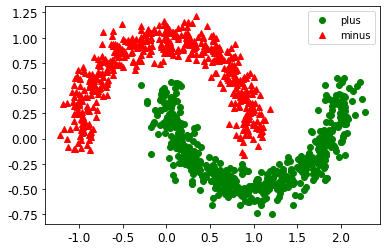

In [59]:
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="plus")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="minus")
plt.legend()
plt.show()

#### 모든 샘플에 추가적인 편향 특성($x_0 = 1$)을 추가 
- 입력 행렬 $\mathbf{X}$의 왼쪽에 1로 채워진 열을 추가

In [60]:
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]

In [61]:
X_moons_with_bias[:10]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665],
       [ 1.        ,  0.61370557, -0.24236929],
       [ 1.        ,  0.2864947 , -0.20127661],
       [ 1.        , -0.05610416,  0.4770791 ],
       [ 1.        ,  1.60421687, -0.30354141],
       [ 1.        ,  0.70964149,  0.85886674]])

#### `y_train`의 크기를 바꾸어 열 벡터로 만들기(하나의 열이 있는 2D 배열)

In [62]:
y_moons_column_vector = y_moons.reshape(-1, 1)

In [63]:
y_moons_column_vector[:10]

array([[1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0]], dtype=int64)

#### 데이터셋을 training set과 test set으로 나누기
- train : test = 8 : 2

In [64]:
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

#### 훈련 배치를 생성하기 위한 간단한 함수 만들기
- 각 배치를 위해 훈련 세트에서 랜덤하게 샘플을 선택함
- 하나의 배치에 동일한 샘플이 여러번 들어갈 수 있고 한 번의 에포크에 모든 훈련 샘플이 포함되지 않을 수도 있음

In [65]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

In [66]:
X_batch, y_batch = random_batch(X_train, y_train, 5)
X_batch

array([[ 1.        ,  1.93189866,  0.13158788],
       [ 1.        ,  1.07172763,  0.13482039],
       [ 1.        , -1.01148674, -0.04686381],
       [ 1.        ,  0.02201868,  0.19079139],
       [ 1.        , -0.98941204,  0.02473116]])

In [67]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]], dtype=int64)

### 모델 생성

#### 기본 그래프 reset

In [68]:
reset_graph()

#### _moons_ 데이터셋은 두 개의 입력 특성을 가지므로 각 샘플은 평면 위의 한 점임 (2차원)

In [69]:
n_inputs = 2

#### logistic regression model
- 먼저 (선형 회귀 모델과 동일하게) 입력의 가중치 합을 계산하고 그 결과를 시그모이드 함수에 적용하여 양성 클래스에 대한 추정 확률을 만듬
- $\hat{p} = h_\mathbf{\theta}(\mathbf{x}) = \sigma(\mathbf{\theta}^T \cdot \mathbf{x})$


- $\mathbf{\theta}$는 편향 $\theta_0$와 가중치 $\theta_1, \theta_2, \dots, \theta_n$를 포함한 파라미터 벡터임
- 입력 벡터 $\mathbf{x}$는 상수 항 $x_0 = 1$과 입력 특성 $x_1, x_2, \dots, x_n$을 포함함
- 한 번에 여러 샘플에 대한 예측을 만들 수 있어야 하므로 하나의 입력 벡터보다는 입력 행렬 $\mathbf{X}$를 사용함
  - $i^{th}$ 번째 행이 $i^{th}$ 번째 입력 벡터의 전치$(\mathbf{x}^{(i)})^T$임
- 다음 식을 사용하여 각 샘플이 양성 클래스에 속할 확률을 추정할 수 있음
  - $ \hat{\mathbf{p}} = \sigma(\mathbf{X} \cdot \mathbf{\theta})$

In [70]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42), name="theta")
logits = tf.matmul(X, theta, name="logits")
y_proba = 1 / (1 + tf.exp(-logits)) # sigmoid function

In [71]:
y_proba = tf.sigmoid(logits)

- Loss function for logistic regression
  - $J(\mathbf{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}$

In [72]:
epsilon = 1e-7  # 로그를 계산할 때 오버플로우를 피하기 위함
loss = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1 - y) * tf.log(1 - y_proba + epsilon))

In [73]:
loss = tf.losses.log_loss(y, y_proba)  # 기본적으로 epsilon = 1e-7 가 사용됨

W1019 10:58:47.932036 17028 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\losses\losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### optimizer 만들기 및 loss function 최소화

In [74]:
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

#### 변수 초기화

In [75]:
init = tf.global_variables_initializer()

#### 모델 훈련

In [76]:
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("EPOCH:", epoch, "\tLoss:", loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

EPOCH: 0 	Loss: 0.79260236
EPOCH: 100 	Loss: 0.34346348
EPOCH: 200 	Loss: 0.3075404
EPOCH: 300 	Loss: 0.29288894
EPOCH: 400 	Loss: 0.28533572
EPOCH: 500 	Loss: 0.28047803
EPOCH: 600 	Loss: 0.27808294
EPOCH: 700 	Loss: 0.27615443
EPOCH: 800 	Loss: 0.27551997
EPOCH: 900 	Loss: 0.27491233


#### `y_proba_val` : 해당 샘플이 양성 클래스에 속할 모델의 추정 확률

In [77]:
y_proba_val[:10]

array([[0.54895616],
       [0.7072436 ],
       [0.51900256],
       [0.99111354],
       [0.50859046],
       [0.01036888],
       [0.97562623],
       [0.03923833],
       [0.437988  ],
       [0.63869727]], dtype=float32)

#### 각 샘플을 분류하기 위해서 최대 가능도 방법(maximum likelihood)을 사용함
- 추정 확률이 0.5보다 크거나 같으면 양성으로 분류함

In [78]:
y_pred = (y_proba_val >= 0.5)
y_pred[:10]

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True]])

#### 경우에 따라 0.5말고 다른 임계값을 사용해야 함
- 높은 정밀도(대신 낮은 재현율)를 원한다면 임계값을 높이고 재현율을 높이려면(대신 낮은 정밀도) 임계값을 낮춤

In [79]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred) # 정밀도

0.8627450980392157

In [80]:
recall_score(y_test, y_pred) # 재현율

0.8888888888888888

#### 그래프를 통한 예측결과 확인

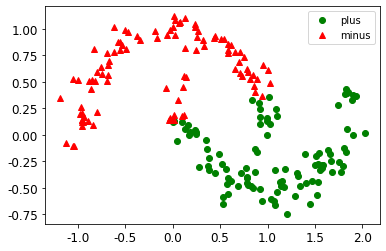

In [81]:
y_pred_idx = y_pred.reshape(-1) # 열 벡터를 1차원 배열로 바꿈
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="plus")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="minus")
plt.legend()
plt.show()

#### 성능 향상을 위한 모든 부가 기능을 추가
* 재사용이 용이하도록 `logistic_regression()` 함수 안에서 그래프를 정의
* 훈련하는 동안 일정한 간격으로 `Saver` 객체를 사용해 체크포인트를 저장하고 훈련이 끝날 때 최종 모델을 저장
* 훈련이 중지되고 다시 시작할 때 마지막 체크포인트를 복원
* 텐서보드에서 그래프가 잘 정돈되어 보이도록 이름 범위를 사용하여 그래프를 정의
* 서머리(summary)를 추가해 텐서보드에서 학습 곡선을 표시
* 학습률, 미니배치 크기 같은 하이퍼파라미터를 바꾸어 보면서 학습 곡선의 모양을 관찰

#### 입력에 ${x_1}^2$, ${x_2}^2$, ${x_1}^3$ 그리고 ${x_2}^3$ 네 개의 특성을 추가
- 모델의 성능 향상에 도움을 줌

In [82]:
X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

In [83]:
X_train_enhanced[:5]

array([[ 1.00000000e+00, -5.14696757e-02,  4.44198631e-01,
         2.64912752e-03,  1.97312424e-01, -1.36349734e-04,
         8.76459084e-02],
       [ 1.00000000e+00,  1.03201691e+00, -4.19741157e-01,
         1.06505890e+00,  1.76182639e-01,  1.09915879e+00,
        -7.39511049e-02],
       [ 1.00000000e+00,  8.67891864e-01, -2.54827114e-01,
         7.53236288e-01,  6.49368582e-02,  6.53727646e-01,
        -1.65476722e-02],
       [ 1.00000000e+00,  2.88850997e-01, -4.48668621e-01,
         8.34348982e-02,  2.01303531e-01,  2.41002535e-02,
        -9.03185778e-02],
       [ 1.00000000e+00, -8.33439108e-01,  5.35056649e-01,
         6.94620746e-01,  2.86285618e-01, -5.78924095e-01,
         1.53179024e-01]])

In [84]:
reset_graph() # 기본 그래프 초기화

#### 로지스틱 회귀 함수 정의

In [85]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

#### 텐서보드를 위해 summary를 저장할 로그 디렉토리 이름을 생성하는 함수 만들기

In [86]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

#### 로지스틱 회귀 함수를 사용한 그래프 및 텐서보드용 서머리를 로그 디렉토리에 저장하기 위한 FileWriter 만들기

In [87]:
n_inputs = 2 + 4
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [88]:
import os

In [89]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt" # 체크포인트 저장경로
checkpoint_epoch_path = checkpoint_path + ".epoch" # 반복횟수 저장경로
final_model_path = "./my_logreg_model" # 최종모델 저장경로

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # 체크포인트 파일이 있으면 모델을 복원하고 에포크 횟수를 로드
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("중지되었던 훈련입니다. 에포크를 이어갑니다.", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0: # 반복횟수가 500일때마다 결과 저장
            print("에포크:", epoch, "\t손실:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

에포크: 0 	손실: 0.62998503
에포크: 500 	손실: 0.16122366
에포크: 1000 	손실: 0.1190321
에포크: 1500 	손실: 0.097329214
에포크: 2000 	손실: 0.08369793
에포크: 2500 	손실: 0.07437582
에포크: 3000 	손실: 0.06750215
에포크: 3500 	손실: 0.062206898
에포크: 4000 	손실: 0.058026787
에포크: 4500 	손실: 0.05456297
에포크: 5000 	손실: 0.051708277
에포크: 5500 	손실: 0.04923773
에포크: 6000 	손실: 0.047167283
에포크: 6500 	손실: 0.045376644
에포크: 7000 	손실: 0.04381875
에포크: 7500 	손실: 0.042374235
에포크: 8000 	손실: 0.041089173
에포크: 8500 	손실: 0.039970923
에포크: 9000 	손실: 0.038920265
에포크: 9500 	손실: 0.038010757
에포크: 10000 	손실: 0.037155706


In [90]:
y_pred = (y_proba_val >= 0.5)

In [91]:
precision_score(y_test, y_pred) # 정밀도

0.9797979797979798

In [92]:
recall_score(y_test, y_pred) # 재현율

0.9797979797979798

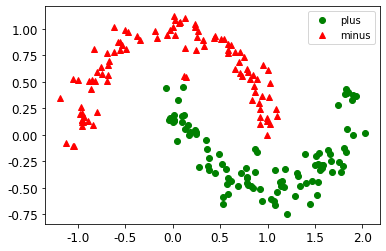

In [93]:
y_pred_idx = y_pred.reshape(-1) # 열 벡터 대신 1차원 배열
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="plus")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="minus")
plt.legend()
plt.show()

#### hyperparameter(가령, batch_size나 learning_rate)를 조정하면서 훈련을 여러번 실행 후 결과 비교

In [94]:
from scipy.stats import reciprocal

n_search_iterations = 10

for search_iteration in range(n_search_iterations):
    batch_size = np.random.randint(1, 100)
    learning_rate = reciprocal(0.0001, 0.1).rvs(random_state=search_iteration) # 랜덤표본생성(random variable sampling)

    n_inputs = 2 + 4
    logdir = log_dir("logreg")
    
    print("반복", search_iteration)
    print("  logdir:", logdir)
    print("  batch_size:", batch_size)
    print("  learning_rate:", learning_rate)
    print("  훈련: ", end="")

    reset_graph()

    X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
    y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

    y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(
        X, y, learning_rate=learning_rate)

    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    n_epochs = 10001
    n_batches = int(np.ceil(m / batch_size))

    final_model_path = "./my_logreg_model_%d" % search_iteration

    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
            file_writer.add_summary(summary_str, epoch)
            if epoch % 500 == 0:
                print(".", end="")

        saver.save(sess, final_model_path)

        print()
        y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
        y_pred = (y_proba_val >= 0.5)
        
        print("  정밀도:", precision_score(y_test, y_pred))
        print("  재현율:", recall_score(y_test, y_pred))

반복 0
  logdir: tf_logs/logreg-run-20191019020006/
  batch_size: 54
  learning_rate: 0.004430375245218265
  훈련: .....................
  정밀도: 0.9797979797979798
  재현율: 0.9797979797979798
반복 1
  logdir: tf_logs/logreg-run-20191019020115/
  batch_size: 22
  learning_rate: 0.0017826497151386947
  훈련: .....................
  정밀도: 0.9797979797979798
  재현율: 0.9797979797979798
반복 2
  logdir: tf_logs/logreg-run-20191019020357/
  batch_size: 74
  learning_rate: 0.00203228544324115
  훈련: .....................
  정밀도: 0.9696969696969697
  재현율: 0.9696969696969697
반복 3
  logdir: tf_logs/logreg-run-20191019020502/
  batch_size: 58
  learning_rate: 0.004491523825137997
  훈련: .....................
  정밀도: 0.9797979797979798
  재현율: 0.9797979797979798
반복 4
  logdir: tf_logs/logreg-run-20191019020615/
  batch_size: 61
  learning_rate: 0.07963234721775589
  훈련: .....................
  정밀도: 0.9801980198019802
  재현율: 1.0
반복 5
  logdir: tf_logs/logreg-run-20191019020710/
  batch_size: 92
  learning_rate: 0.00046